### 准备部分，包含读文件(read_text)，以及将文本切分为句子(split_into_en_sentences,split_into_ch_sentences)
#### 这三个函数写在了./app/utils.py中，使用前import utils即可

In [1]:
def read_text(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        text = ''.join(file.readlines())
        return text

In [2]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"

def split_into_en_sentences_modified_1(text):
    '''<stop>是人为添加的'标识符'，目的是为了最后统一用<stop>来split句子
    参考https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences'''
    text = " " + text + "  "
    text = text.replace("\n","<stop>")
    '''修改的地方：将("\n"," ")改为("\n","<stop>")
    为了使小标题或其他有换行但没有标点的地方，也可以顺利分开'''
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    while '' in sentences:
        sentences.remove('')
    '''
    由于最开始将\n替换为了<stop>，而<stop>最后会作为分隔符。如果没有remove这行的话，分隔符的地方会多出空的字符串
    '''
    return sentences

In [3]:
def split_into_ch_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n","<stop>")
    if "”" in text: text = text.replace("。”","”。")
    if "\"" in text: text = text.replace("。\"","\"。")
    if "！" in text: text = text.replace("！\"","\"！")
    if "？" in text: text = text.replace("？\"","\"？")
    text = text.replace("。","。<stop>")
    text = text.replace("？","？<stop>")
    text = text.replace("！","！<stop>")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    while '' in sentences:
        sentences.remove('')
    '''
    由于最开始将\n替换为了<stop>，而<stop>最后会作为分隔符。如果没有remove这行的话，分隔符的地方会多出空的字符串
    '''
    return sentences

In [4]:
en_text = read_text('c:\\Users\\zhouy217\\OneDrive - Pfizer\\Documents\\data_pipeline\\data\\text2.txt')

In [5]:
en_text#如运行结果所示，保留了换行符\n

"I enjoyd the event which took place yesteday & I lovdddd itttt ! \nThe link to the show is http://t.co/4ftYom0i. It's awesome you'll luv it #HadFun #Enjoyed BFN GN\n\nBest of all, NLTK is a free, open source, community-driven project.\n\nNLTK has been called “a wonderful tool for teaching, and working in, computational linguistics using Python,” and “an amazing library to play with natural language.”"

In [6]:
en_result_list=split_into_en_sentences_modified_1(en_text)
en_result_list

['I enjoyd the event which took place yesteday & I lovdddd itttt !',
 'The link to the show is http://t.',
 'co/4ftYom0i.',
 "It's awesome you'll luv it #HadFun #Enjoyed BFN GN",
 'Best of all, NLTK is a free, open source, community-driven project.',
 'NLTK has been called “a wonderful tool for teaching, and working in, computational linguistics using Python,” and “an amazing library to play with natural language”.']

### 主体用LaBSE做text alignment部分,match部分的代码写在了./app/text_alignment.py中的sentence_similarity_calculate函数里
#### 下面展示了polyfuzz的使用例子，包括polyfuzz结合LaBSE并用一篇英文及中文译文作了试验、polyfuzz的匹配规则。

In [12]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from polyfuzz import PolyFuzz
from polyfuzz.models import Embeddings
from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import SentenceTransformerDocumentEmbeddings

C:\ANACONDA3\envs\ja_nlp_python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
embeddings = SentenceTransformerDocumentEmbeddings('LaBSE')
LaBSE = Embeddings(embeddings,min_similarity=0,model_id='LaBSE')
model=PolyFuzz([LaBSE])

In [27]:
en_sentences = read_text('c:\\Users\\zhouy217\\OneDrive - Pfizer\\Documents\\data_pipeline\\data\\en_material1.txt')
en_result_list=split_into_en_sentences_modified_1(en_sentences)
en_result_list

['The article gives an overview of the sentence alignment process and how to build them using a scalable pipeline.',
 'We also talk about the challenges faced as part of the Project Anuvaad (an Indic based translation system) in performing alignment at scale and how it was optimized using FAISS for considerable performance improvement in curating the bi-lingual corpus.',
 'We are one of the biggest contributors to India’s largest publicly available parallel corpus samanantar.',
 'We will also be the early contributors to the ULCA ( Universal Language Contribution API ) system.',
 'Bilingual Sentence Alignment',
 'Bilingual Sentence alignment (or cross-language semantic similarity) is defined as searching through two available collections of sentences and identifying meaningfully matching sentence pairs (if any) among them.',
 'First, to get a detailed idea about the whole process, let’s start from the basics.',
 'Consider two lists, having similar (but not exactly matching) sentences.'

In [28]:
len(en_result_list)

25

In [31]:
ch_sentences = read_text('c:\\Users\\zhouy217\\OneDrive - Pfizer\\Documents\\data_pipeline\\data\\ch_material1.txt')
ch_result_list=split_into_ch_sentences(ch_sentences)
ch_result_list

['本文概述了句子对齐过程以及如何使用可扩展的管道构建它们。',
 '我们还讨论了作为 Project Anuvaad（一个基于印度语的翻译系统）的一部分在执行大规模对齐方面所面临的挑战，以及如何使用 FAISS 对其进行优化以显着提高双语语料库的管理性能。',
 '我们是印度最大的公开平行语料库 samanantar 的最大贡献者之一。',
 '我们也将成为 ULCA（通用语言贡献 API）系统的早期贡献者。',
 '双语句子对齐',
 '双语句子对齐（或跨语言语义相似性）被定义为搜索两个可用的句子集合并在其中识别有意义匹配的句子对（如果有）。',
 '首先，要详细了解整个过程，让我们从基础开始。',
 '考虑两个具有相似（但不完全匹配）句子的列表。',
 'aligner 背后的想法是识别“我的名字是阿斯温”和“阿斯温，那是我的名字”这样的情况都是相似的。',
 '尽管问题乍一看似乎很复杂，但有许多方法可以实现这一目标。',
 '可以使用 Fuzzywuzzy、Word2vec、TF-IDF 等基本方法来实现相同的目的。',
 '不过，在复杂输入中提取质量对有点棘手，我们将在后面讨论。',
 '但是，这里的想法是要确定如果语言对是英语-英语，这样做相对简单。',
 '可以参考这篇文章来详细了解这里的各种方法。',
 '下面的代码解释了一种在语言为 en-en 时查找匹配对的简单方法。',
 '即使这种简单的方法在基本情况下有效，我们也不能指望它在复杂和模棱两可的情况下提供理想的输出。',
 '因此，我们需要切换到基于模型的方法。',
 '此外，由于我们的目标是对双语文本进行对齐，现在让我们从现在开始在这种情况下思考，因为同样的方法也可以应用于单语案例。',
 '为了实现这一点，我们利用预训练的编码器-解码器模型将这些句子转换为向量表示，然后使用这些向量表示（称为嵌入）来计算句子之间的相似度。',
 '在进一步搜索中，我们入围了两个模型，LASER（来自 Facebook）和 LaBSE（来自 Google）。',
 '在本文中，Vishal Mahuli 解释了它们之间的比较。',
 '由于 LaBSE 为印度语言提供了更好的输出，因此它被用作 Anuvaad 项目 (https://anuvaad.org/) 的一部分。',
 '基本实现',
 '使用 LaB

In [32]:
len(ch_result_list)

25

In [33]:
model.match(en_result_list,ch_result_list)
df=model.get_matches()
df

,From,To,Similarity
0,The article gives an overview of the sentence ...,本文概述了句子对齐过程以及如何使用可扩展的管道构建它们。,0.867
1,We also talk about the challenges faced as par...,我们还讨论了作为 Project Anuvaad（一个基于印度语的翻译系统）的一部分在执行大...,0.923
2,We are one of the biggest contributors to Indi...,我们是印度最大的公开平行语料库 samanantar 的最大贡献者之一。,0.840
3,We will also be the early contributors to the ...,我们也将成为 ULCA（通用语言贡献 API）系统的早期贡献者。,0.959
4,Bilingual Sentence Alignment,双语句子对齐,0.806
5,Bilingual Sentence alignment (or cross-languag...,双语句子对齐（或跨语言语义相似性）被定义为搜索两个可用的句子集合并在其中识别有意义匹配的句子...,0.913
6,"First, to get a detailed idea about the whole ...",首先，要详细了解整个过程，让我们从基础开始。,0.880
7,"Consider two lists, having similar (but not ex...",考虑两个具有相似（但不完全匹配）句子的列表。,0.918
8,The idea behind aligner is to identify cases l...,aligner 背后的想法是识别“我的名字是阿斯温”和“阿斯温，那是我的名字”这样的情况都是...,0.889
9,Even Though the problem seems complex at the f...,尽管问题乍一看似乎很复杂，但有许多方法可以实现这一目标。,0.910


为计算只含部分信息的译文，相似度上的均值和标准差


In [22]:
def split_into_ch_sentences(text):
    '''！！！此函数为了构造只含有部分信息的译文'''
    import re
    ch_result_list = re.split(r'[。！？……\s]', ch_sentences)
    #加了\s所有的空格的地方都会分割，为了构造出
    while '' in ch_result_list:
        ch_result_list.remove('')#确保放进polyfuzz的model的句子中没有空字符串
    '''
    如果句子列表中有字符串为空，会报
    141 Warning: An empty Sentence was created! Are there empty strings in your dataset?
    '''
    return ch_result_list
ch_sentences = read_text('c:\\Users\\zhouy217\\OneDrive - Pfizer\\Documents\\data_pipeline\\data\\ch_material_all.txt')
ch_result_list=split_into_ch_sentences(ch_sentences)
ch_result_list

['本文概述了句子对齐过程以及如何使用可扩展的管道构建它们',
 '我们还讨论了作为',
 'Project',
 'Anuvaad（一个基于印度语的翻译系统）的一部分在执行大规模对齐方面所面临的挑战，以及如何使用',
 'FAISS',
 '对其进行优化以显着提高双语语料库的管理性能',
 '我们是印度最大的公开平行语料库',
 'samanantar',
 '的最大贡献者之一',
 '我们也将成为',
 'ULCA（通用语言贡献',
 'API）系统的早期贡献者',
 '双语句子对齐',
 '双语句子对齐（或跨语言语义相似性）被定义为搜索两个可用的句子集合并在其中识别有意义匹配的句子对（如果有）',
 '首先，要详细了解整个过程，让我们从基础开始',
 '考虑两个具有相似（但不完全匹配）句子的列表',
 'aligner',
 '背后的想法是识别“我的名字是阿斯温”和“阿斯温，那是我的名字”这样的情况都是相似的',
 '尽管问题乍一看似乎很复杂，但有许多方法可以实现这一目标',
 '可以使用',
 'Fuzzywuzzy、Word2vec、TF-IDF',
 '等基本方法来实现相同的目的',
 '不过，在复杂输入中提取质量对有点棘手，我们将在后面讨论',
 '但是，这里的想法是要确定如果语言对是英语-英语，这样做相对简单',
 '可以参考这篇文章来详细了解这里的各种方法',
 '下面的代码解释了一种在语言为',
 'en-en',
 '时查找匹配对的简单方法',
 '即使这种简单的方法在基本情况下有效，我们也不能指望它在复杂和模棱两可的情况下提供理想的输出',
 '因此，我们需要切换到基于模型的方法',
 '此外，由于我们的目标是对双语文本进行对齐，现在让我们从现在开始在这种情况下思考，因为同样的方法也可以应用于单语案例',
 '为了实现这一点，我们利用预训练的编码器-解码器模型将这些句子转换为向量表示，然后使用这些向量表示（称为嵌入）来计算句子之间的相似度',
 '在进一步搜索中，我们入围了两个模型，LASER（来自',
 'Facebook）和',
 'LaBSE（来自',
 'Google）',
 '在本文中，Vishal',
 'Mahuli',
 '解释了它们之间的比较',
 '由于',
 'LaBSE',
 '为印度语言提供了更好的输出，因此它被用作

In [23]:
len(ch_result_list)

235

In [42]:
en_sentences = read_text('c:\\Users\\zhouy217\\OneDrive - Pfizer\\Documents\\data_pipeline\\data\\en_material_entire_paragraphs.txt')
en_result_list=split_into_en_sentences_modified_1(en_sentences)
en_result_list

['The article gives an overview of the sentence alignment process and how to build them using a scalable pipeline.',
 'We also talk about the challenges faced as part of the Project Anuvaad (an Indic based translation system) in performing alignment at scale and how it was optimized using FAISS for considerable performance improvement in curating the bi-lingual corpus.',
 'We are one of the biggest contributors to India’s largest publicly available parallel corpus samanantar.',
 'We will also be the early contributors to the ULCA ( Universal Language Contribution API ) system.',
 'Bilingual Sentence Alignment',
 'Bilingual Sentence alignment (or cross-language semantic similarity) is defined as searching through two available collections of sentences and identifying meaningfully matching sentence pairs (if any) among them.',
 'First, to get a detailed idea about the whole process, let’s start from the basics.',
 'Consider two lists, having similar (but not exactly matching) sentences.'

In [43]:
model.match(en_result_list,ch_result_list)
df=model.get_matches()
df

,From,To,Similarity
0,The article gives an overview of the sentence ...,本文概述了句子对齐过程以及如何使用可扩展的管道构建它们。,0.867
1,We also talk about the challenges faced as par...,我们还讨论了作为 Project Anuvaad（一个基于印度语的翻译系统）的一部分在执行大...,0.923
2,We are one of the biggest contributors to Indi...,我们是印度最大的公开平行语料库 samanantar 的最大贡献者之一。,0.840
3,We will also be the early contributors to the ...,我们也将成为 ULCA（通用语言贡献 API）系统的早期贡献者。,0.959
4,Bilingual Sentence Alignment,双语句子对齐,0.806
...,...,...,...
116,Takeaway,基本实现,0.232
117,"As expected, the search is a bit slower than t...",尽管问题乍一看似乎很复杂，但有许多方法可以实现这一目标。,0.315
118,Quality of output increased but still not up t...,不过，在复杂输入中提取质量对有点棘手，我们将在后面讨论。,0.331
119,Quality decreases considerably as and when the...,不过，在复杂输入中提取质量对有点棘手，我们将在后面讨论。,0.243


<AxesSubplot:xlabel='Similarity', ylabel='Density'>

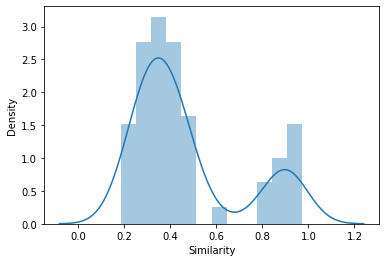

In [44]:
import seaborn as sns
sns.distplot(df['Similarity'])
#从下图可以看出，只包含部分信息的句子，匹配相似度较低；可以考虑设置阈值为0.6用来筛除只包含部分信息的句子

In [45]:
df['Similarity'].mean()

0.4660495867768595

In [46]:
df['Similarity'].std()

0.232552067690932

#### polyfuzz的使用，以及匹配规则
polyfuzz官网https://maartengr.github.io/PolyFuzz/

匹配以source_sentences（.match()的第一个参数）为准，见下面示例

句子数不等时，可以考虑将句子数少的句子列表放在第一个参数中

In [7]:
from polyfuzz import PolyFuzz
source_sentences = ['my name is Tom','The main ingredient of this product is fluconazole','I love NLP']
target_sentences = ['Tom, that is my name','本品主要成份为氟康唑']
model = PolyFuzz('TF-IDF')#选用tfidf只适用于英语
model.match(source_sentences,target_sentences)
model.get_matches()

C:\ANACONDA3\envs\ja_nlp_python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,From,To,Similarity
0,my name is Tom,"Tom, that is my name",0.703
1,The main ingredient of this product is flucona...,None,0.000
2,I love NLP,None,0.000


In [13]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from polyfuzz import PolyFuzz
from polyfuzz.models import Embeddings
from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import SentenceTransformerDocumentEmbeddings
embeddings = SentenceTransformerDocumentEmbeddings('LaBSE')
LaBSE = Embeddings(embeddings,min_similarity=0,model_id='LaBSE')
model=PolyFuzz([LaBSE])

source sentences与target sentence一样多

In [14]:
source_sentences = ['The most frequently (>1/10) reported adverse reactions are headache, abdominal pain, diarrhoea, nausea, vomiting, alanine aminotransferase increased, aspartate aminotransferase increased, blood alkaline phosphatase increased and rash.','The main ingredient of this product is fluconazole','Reporting suspected adverse reactions after authorisation of the medicinal product is important.','It allows continued monitoring of the benefit/risk balance of the medicinal product.','Healthcare professionals are asked to report any suspected adverse reactions.']
target_sentences = ['疑似不良反应报告在药品批准后报告可疑的不良反应很重要。','它允许持续监测药品的收益/风险平衡。','要求医疗保健专业人员报告任何可疑的不良反应。','最常见（>1/10）报告的不良反应是头痛、腹痛、腹泻、恶心、呕吐、丙氨酸氨基转移酶升高、天冬氨酸氨基转移酶升高、血碱性磷酸酶升高和皮疹。','本品主要成份为氟康唑']

model.match(source_sentences,target_sentences)
model.get_matches()

,From,To,Similarity
0,The most frequently (>1/10) reported adverse r...,最常见（>1/10）报告的不良反应是头痛、腹痛、腹泻、恶心、呕吐、丙氨酸氨基转移酶升高、天冬...,0.875
1,The main ingredient of this product is flucona...,本品主要成份为氟康唑,0.782
2,Reporting suspected adverse reactions after au...,疑似不良反应报告在药品批准后报告可疑的不良反应很重要。,0.885
3,It allows continued monitoring of the benefit/...,它允许持续监测药品的收益/风险平衡。,0.924
4,Healthcare professionals are asked to report a...,要求医疗保健专业人员报告任何可疑的不良反应。,0.892


source_sentences多，target_sentences多次出现以匹配source_sentences

In [15]:
source_sentences = ['The most frequently (>1/10) reported adverse reactions are headache, abdominal pain, diarrhoea, nausea, vomiting, alanine aminotransferase increased, aspartate aminotransferase increased, blood alkaline phosphatase increased and rash.','The main ingredient of this product is fluconazole','Reporting suspected adverse reactions after authorisation of the medicinal product is important.','It allows continued monitoring of the benefit/risk balance of the medicinal product.','Healthcare professionals are asked to report any suspected adverse reactions.']
target_sentences = ['疑似不良反应报告在药品批准后报告可疑的不良反应很重要。','要求医疗保健专业人员报告任何可疑的不良反应。','本品主要成份为氟康唑']

model.match(source_sentences,target_sentences)
model.get_matches()

,From,To,Similarity
0,The most frequently (>1/10) reported adverse r...,疑似不良反应报告在药品批准后报告可疑的不良反应很重要。,0.264
1,The main ingredient of this product is flucona...,本品主要成份为氟康唑,0.782
2,Reporting suspected adverse reactions after au...,疑似不良反应报告在药品批准后报告可疑的不良反应很重要。,0.885
3,It allows continued monitoring of the benefit/...,疑似不良反应报告在药品批准后报告可疑的不良反应很重要。,0.307
4,Healthcare professionals are asked to report a...,要求医疗保健专业人员报告任何可疑的不良反应。,0.892


target_sentences多，选了target sentences里与source sentences匹配度高的句子做匹配

In [18]:
source_sentences = ['The main ingredient of this product is fluconazole','It allows continued monitoring of the benefit/risk balance of the medicinal product.','Healthcare professionals are asked to report any suspected adverse reactions.']
target_sentences = ['疑似不良反应报告在药品批准后报告可疑的不良反应很重要。','它允许持续监测药品的收益/风险平衡。','要求医疗保健专业人员报告任何可疑的不良反应。','最常见（>1/10）报告的不良反应是头痛、腹痛、腹泻、恶心、呕吐、丙氨酸氨基转移酶升高、天冬氨酸氨基转移酶升高、血碱性磷酸酶升高和皮疹。','本品主要成份为氟康唑']

model.match(source_sentences,target_sentences)
model.get_matches()

,From,To,Similarity
0,The main ingredient of this product is flucona...,本品主要成份为氟康唑,0.782
1,It allows continued monitoring of the benefit/...,它允许持续监测药品的收益/风险平衡。,0.924
2,Healthcare professionals are asked to report a...,要求医疗保健专业人员报告任何可疑的不良反应。,0.892


### 其他

In [8]:
type(model.get_matches)

method

In [20]:
df=model.get_matches()
df.loc[df['Similarity'] > 0.7] #filter df by column values
df

,From,To,Similarity
0,The main ingredient of this product is flucona...,本品主要成份为氟康唑,0.782
1,It allows continued monitoring of the benefit/...,它允许持续监测药品的收益/风险平衡。,0.924
2,Healthcare professionals are asked to report a...,要求医疗保健专业人员报告任何可疑的不良反应。,0.892


#### 下面这个读文本文件的函数不能用，读入之后不含换行符\n

In [141]:
def read_file_as_text(file_name, quotechar=None):
    '''
    input:txt
    output:string
    '''
    import csv
    import itertools
    with open(file_name, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t', quotechar=quotechar)
        lines = []
        for line in reader:
            if sys.version_info[0] == 2:
                line = list(unicode(cell, 'utf-8') for cell in line)
            lines.append(line)
        content=''.join(list(itertools.chain(*lines)))
    return content
    # return lines

In [142]:
en_passage = read_file_as_text('c:\\Users\\zhouy217\\OneDrive - Pfizer\\Documents\\data_pipeline\\data\\text2.txt')

In [143]:
en_passage

"I enjoyd the event which took place yesteday & I lovdddd itttt ! The link to the show is http://t.co/4ftYom0i. It's awesome you'll luv it #HadFun #Enjoyed BFN GNBest of all, NLTK is a free, open source, community-driven project.NLTK has been called “a wonderful tool for teaching, and working in, computational linguistics using Python,” and “an amazing library to play with natural language.”"